In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)


In [58]:
dataFrame = pd.read_csv('/content/drive/My Drive/data/viettri_quality.csv', index_col='date')

In [59]:
dataFrame

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,44,17,29,2,9,4
3/2/2019,65,37,27,4,12,4
3/3/2019,81,38,2,1,1,2
3/4/2019,51,24,21,4,8,1
3/5/2019,43,7,23,1,12,4
...,...,...,...,...,...,...
5/28/2024,38,24,35,1,15,5
5/29/2024,38,17,41,7,15,10
5/30/2024,28,8,11,1,15,1


In [60]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0) # Handling missing values, fill with 0 instead of removing
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['pm25']] = target_scaler.fit_transform(dataFrame[['pm25']].to_numpy())
df_scaled = df_scaled.astype(float)

In [61]:
# Single step dataset preparation
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['pm25']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)


In [62]:
# Dataset splitting
SPLIT = 0.8
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [63]:
n_forecast = 5

In [64]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(30, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(n_forecast, activation='linear'))
model_gru.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 30)                3420      
                                                                 
 dropout_3 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 155       
                                                                 
Total params: 3575 (13.96 KB)
Trainable params: 3575 (13.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
history = model_gru.fit(X_train, y_train, epochs=20)

Epoch 1/20
48/48 [==============================] - 3s 10ms/step - loss: 0.0421 - MAE: 0.1518
Epoch 2/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0294 - MAE: 0.1284
Epoch 3/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0245 - MAE: 0.1146
Epoch 4/20
48/48 [==============================] - 1s 10ms/step - loss: 0.0232 - MAE: 0.1093
Epoch 5/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0230 - MAE: 0.1073
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0224 - MAE: 0.1060
Epoch 7/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0212 - MAE: 0.1019
Epoch 8/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0206 - MAE: 0.1000
Epoch 9/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0209 - MAE: 0.1002
Epoch 10/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0211 - MAE: 0.0993
Epoch 11/20
48/48 [==============================] - 0s 10m

In [66]:
# Reload the data with the date index
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv') # Assuming the CSV file contains a 'Date' column
dataFrame['date'] = pd.to_datetime(dataFrame['date'])
dataFrame.set_index('date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = model_gru.predict(X_test)

d = {
	'Predicted_pm25': predicted_values[:, 0],
 'Actual_pm25': y_test[:, 0],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index


12/12 [==============================] - 1s 5ms/step


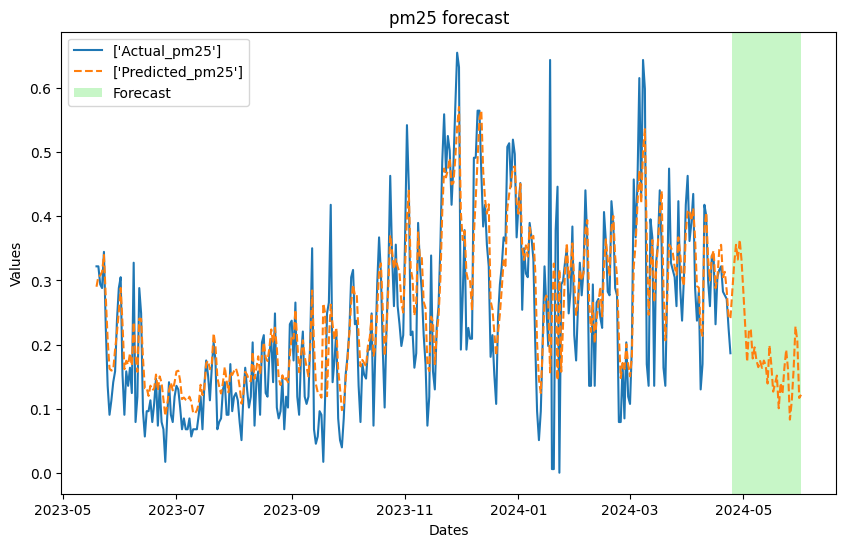

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_pm25']][:highlight_start], label=['Actual_pm25'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_pm25']], label=['Predicted_pm25'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('pm25 forecast')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [68]:
predicted_values

array([[0.2902041 , 0.2907282 , 0.30610812, 0.278932  , 0.29459   ],
       [0.3062363 , 0.3151819 , 0.32607615, 0.30159327, 0.3204155 ],
       [0.30777356, 0.30482855, 0.3178993 , 0.29762837, 0.31246376],
       ...,
       [0.2051495 , 0.1853722 , 0.1934858 , 0.18891782, 0.19294839],
       [0.11661446, 0.11657081, 0.11880808, 0.11318003, 0.10291889],
       [0.12160817, 0.120627  , 0.12237996, 0.12052724, 0.11053105]],
      dtype=float32)

In [69]:
predicted_values_90 = predicted_values[:18]

In [70]:
pm25_scaler = target_scaler
# Perform the inverse transformation on the scaled pm25 data
predicted_values_90 = pm25_scaler.inverse_transform(predicted_values_90)

# Check the DataFrame to see the reversed pm25 values
print(predicted_values_90)

[[52.366127 52.458893 55.181137 50.370964 53.14243 ]
 [55.203823 56.787197 58.715477 54.382008 57.713543]
 [55.47592  54.954655 57.268173 53.68022  56.306084]
 [56.48916  55.865986 58.249653 54.45476  57.715744]
 [61.13761  62.37796  64.23168  59.326836 64.455605]
 [49.612434 48.291508 49.806477 49.91438  47.6612  ]
 [37.731243 37.273293 38.704994 39.366486 36.710167]
 [29.746868 28.99675  31.07713  30.094797 29.031065]
 [29.213705 28.71495  30.887701 28.539234 29.96475 ]
 [29.442171 30.081001 31.57109  29.494684 30.572065]
 [35.05071  33.838882 36.21504  32.051346 37.373547]
 [39.746605 41.086014 42.13912  39.321774 42.743862]
 [45.50128  44.233604 45.001842 45.243687 44.38361 ]
 [52.046307 49.90162  51.434975 50.198204 51.350433]
 [42.112137 39.603436 41.70601  41.07143  40.99933 ]
 [29.603544 29.557692 31.187637 30.022467 31.052917]
 [31.935307 31.938646 32.867424 32.061413 32.830544]
 [30.842093 29.608627 31.283802 30.186947 30.207952]]


In [71]:
predicted_values_90 = np.concatenate(predicted_values_90, axis=0)

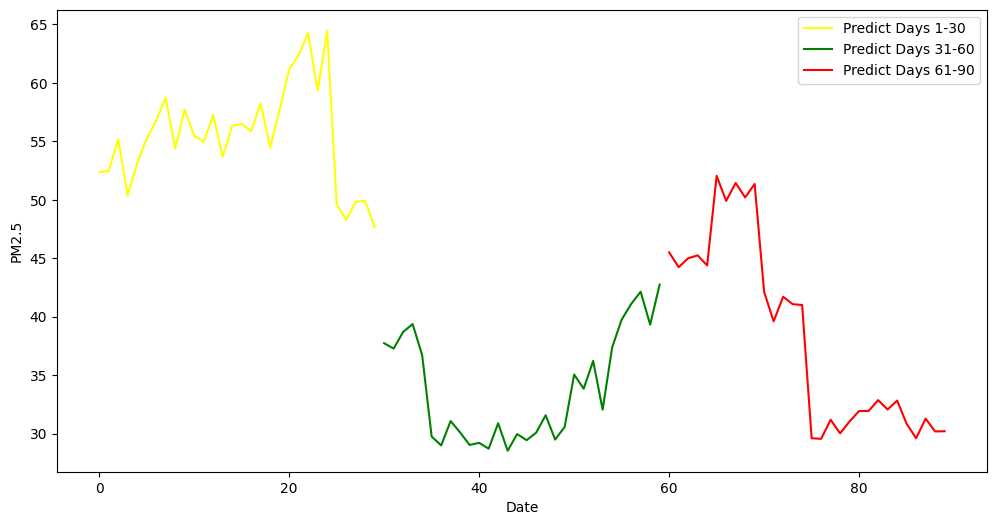

In [72]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
data = pd.DataFrame({'Date': dates, 'predicted_values_90': predicted_values_90})

plt.plot(data['predicted_values_90'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(data['predicted_values_90'][30:60], color='green', label='Predict Days 31-60')
plt.plot(data['predicted_values_90'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
if predicted_values.ndim == 1:
    predicted_values = predicted_values.reshape(-1, 1)

# Inverse transform the predicted values
predicted_values_all = pm25_scaler.inverse_transform(predicted_values)

# Check the shape after inverse transformation
print("Shape of y_test:", y_test.shape)
print("Shape of predicted_values_all:", predicted_values_all.shape)
# Aggregate predictions to match the shape of y_test
predicted_values_aggregated = np.mean(predicted_values_all, axis=1, keepdims=True)

# Calculate the RMSE, MAE, and MAPE
rmse = mean_squared_error(y_test, predicted_values_aggregated, squared=False)
mae = mean_absolute_error(y_test, predicted_values_aggregated)
mape = mean_absolute_percentage_error(y_test, predicted_values_aggregated)

# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)


Shape of y_test: (380, 1)
Shape of predicted_values_all: (380, 5)
RMSE: 48.73288010998827
MAE: 45.01395425419349
MAPE: 696891311578636.9
